### About this file
Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.


#### Attributes

#### People

- `ID`: Customer's unique identifier
- `Year_Birth`: Customer's birth year
- `Education`: Customer's education level
- `Marital_Status`: Customer's marital status
- `Income`: Customer's yearly household income
- `Kidhome`: Number of children in customer's household
- `Teenhome`: Number of teenagers in customer's household
- `Dt_Customer`: Date of customer's enrollment with the company
- `Recency`: Number of days since customer's last purchase
- `Complain`: 1 if the customer complained in the last 2 years, 0 otherwise
    
#### Products:

- `MntWines`: Amount spent on wine in last 2 years
- `MntFruits`: Amount spent on fruits in last 2 years
- `MntMeatProducts`: Amount spent on meat in last 2 years
- `MntFishProducts`: Amount spent on fish in last 2 years
- `MntSweetProducts`: Amount spent on sweets in last 2 years
- `MntGoldProds`: Amount spent on gold in last 2 years
    
#### Promotion:

- `NumDealsPurchases`: Number of purchases made with a discount
- `AcceptedCmp1`: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- `AcceptedCmp2`: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- `AcceptedCmp3`: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- `AcceptedCmp4`: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- `AcceptedCmp5`: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- `Response`: 1 if customer accepted the offer in the last campaign, 0 otherwise

#### Location:

- `NumWebPurchases`: Number of purchases made through the company’s website
- `NumCatalogPurchases`: Number of purchases made using a catalogue
- `NumStorePurchases`: Number of purchases made directly in stores
- `NumWebVisitsMonth`: Number of visits to company’s website in the last month

In [24]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from pandas import MultiIndex, Int64Index

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

import seaborn as sns

import bentoml

/tmp/ipykernel_4239/3548294330.py:12: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
url = "https://raw.githubusercontent.com/DonAvery/my-ds-ml-education-journey/main/ml-zoomcamp/capstone/marketing_campaign.csv"
df = pd.read_csv(url, sep = ';')

## EDA

Transposing the dataframe allows us to easily see the all the columns.

In [3]:
df.head().T

,0,1,2,3,4
ID,5524,2174,4141,6182,5324
Year_Birth,1957,1954,1965,1984,1981
Education,Graduation,Graduation,Graduation,Graduation,PhD
Marital_Status,Single,Single,Together,Together,Married
Income,58138.0,46344.0,71613.0,26646.0,58293.0
Kidhome,0,1,0,1,1
Teenhome,0,1,0,0,0
Dt_Customer,2012-09-04,2014-03-08,2013-08-21,2014-02-10,2014-01-19
Recency,58,38,26,26,94
MntWines,635,11,426,11,173


I don't think the "ID" column adds to our dataset since we have the "Dt_Customer" column, lets use that as the index.

I want to get all the text the same so I will lowercase all the text.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)

A quick analysis of the data shows us there are some null values, count column shows 2240 entries in all columns, except "income".

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
year_birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
mntwines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
mntfruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
mntmeatproducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
mntfishproducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


z_costcontact and z_revenue both have the same value for all records, lets drop those.

In [7]:
del df['z_revenue']
del df['z_costcontact']

In [8]:
df.isnull().sum()

id                      0
year_birth              0
education               0
marital_status          0
income                 24
kidhome                 0
teenhome                0
dt_customer             0
recency                 0
mntwines                0
mntfruits               0
mntmeatproducts         0
mntfishproducts         0
mntsweetproducts        0
mntgoldprods            0
numdealspurchases       0
numwebpurchases         0
numcatalogpurchases     0
numstorepurchases       0
numwebvisitsmonth       0
acceptedcmp3            0
acceptedcmp4            0
acceptedcmp5            0
acceptedcmp1            0
acceptedcmp2            0
complain                0
response                0
dtype: int64

In [9]:
df["income"].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: income, dtype: float64

In [10]:
df['income'].value_counts(bins = 6, sort = False)

(1065.063, 112552.667]      2207
(112552.667, 223375.333]       8
(223375.333, 334198.0]         0
(334198.0, 445020.667]         0
(445020.667, 555843.333]       0
(555843.333, 666666.0]         1
Name: income, dtype: int64

I want to delete these 9 records as they will skew the data.

In [11]:
np.count_nonzero(df.income > 110000.00)

9

In [12]:
df.drop(df[df['income'] >= 111000].index, inplace = True)

Now that we eliminated the 9 rows of outlier incomes we can fill in the rest of the nan incomes with the mean

In [13]:
df['income'].fillna(int(df['income'].mean()), inplace=True)

In [14]:
df.isnull().sum()

id                     0
year_birth             0
education              0
marital_status         0
income                 0
kidhome                0
teenhome               0
dt_customer            0
recency                0
mntwines               0
mntfruits              0
mntmeatproducts        0
mntfishproducts        0
mntsweetproducts       0
mntgoldprods           0
numdealspurchases      0
numwebpurchases        0
numcatalogpurchases    0
numstorepurchases      0
numwebvisitsmonth      0
acceptedcmp3           0
acceptedcmp4           0
acceptedcmp5           0
acceptedcmp1           0
acceptedcmp2           0
complain               0
response               0
dtype: int64

In [15]:
df.dtypes

id                       int64
year_birth               int64
education               object
marital_status          object
income                 float64
kidhome                  int64
teenhome                 int64
dt_customer             object
recency                  int64
mntwines                 int64
mntfruits                int64
mntmeatproducts          int64
mntfishproducts          int64
mntsweetproducts         int64
mntgoldprods             int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
response                 int64
dtype: object

We can see, when calling `dytpes` that we have three non numerical columns, `dt_customer` is a date column, we will worry about that later. `education` and `marital_status` are also both of the object data type. Let's get some unique information from these.

In [16]:
df['education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [17]:
df['marital_status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

## Visualize

Let's visualize some of this data now.

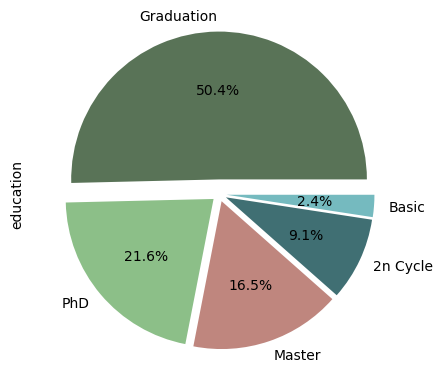

In [18]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF']
explode = [0.1,0.05,0.05,0.05,0.05]

df['education'].value_counts().plot(kind = 'pie', autopct='%.1f%%', colors=colors, explode=explode)
plt.show()

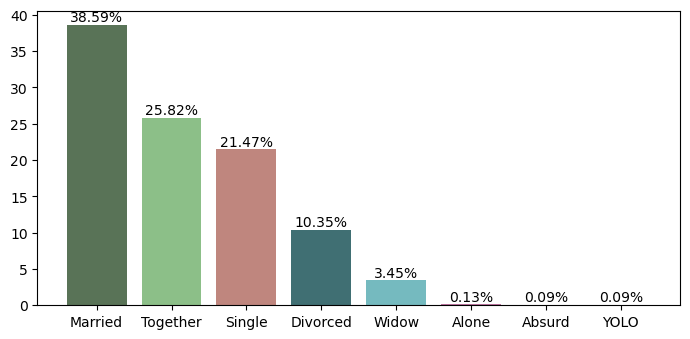

In [19]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF', '#BF75A1', '#6BB9BF', '#95BF91']

percentages = round(((df['marital_status'].value_counts() / df['marital_status'].shape[0]) * 100), 2)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
labels = df['marital_status'].unique()

plt.figure()

p1 = plt.bar(percentages.index, percentages, color=colors)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(height),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

plt.show()

In [20]:
df.columns

Index(['id', 'year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mntwines', 'mntfruits',
       'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1',
       'acceptedcmp2', 'complain', 'response'],
      dtype='object')

<AxesSubplot: >

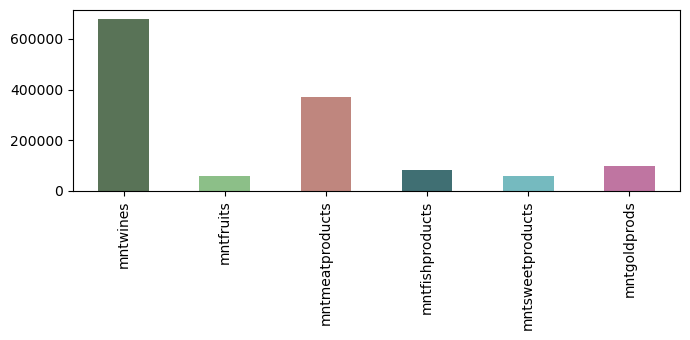

In [21]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF', '#BF75A1', '#6BB9BF', '#95BF91']

cols = ['mntwines',
            'mntfruits',
            'mntmeatproducts',
            'mntfishproducts',
            'mntsweetproducts',
            'mntgoldprods']

df[cols].sum().plot.bar(color=colors)

In [22]:
df.columns

Index(['id', 'year_birth', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'dt_customer', 'recency', 'mntwines', 'mntfruits',
       'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1',
       'acceptedcmp2', 'complain', 'response'],
      dtype='object')

<AxesSubplot: >

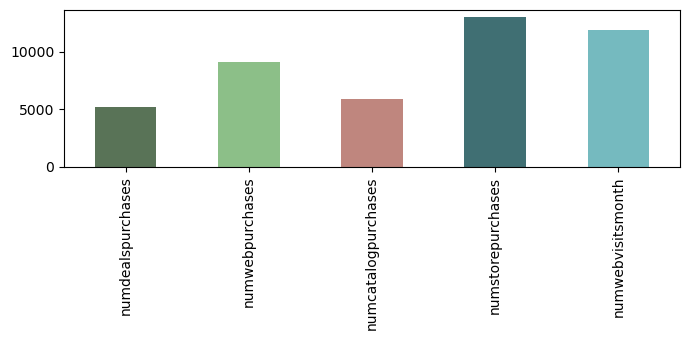

In [23]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF', '#BF75A1', '#6BB9BF', '#95BF91']

cols = ['numdealspurchases',
        'numwebpurchases',
       'numcatalogpurchases',
        'numstorepurchases',
        'numwebvisitsmonth']

df[cols].sum().plot.bar(color=colors)

<AxesSubplot: >

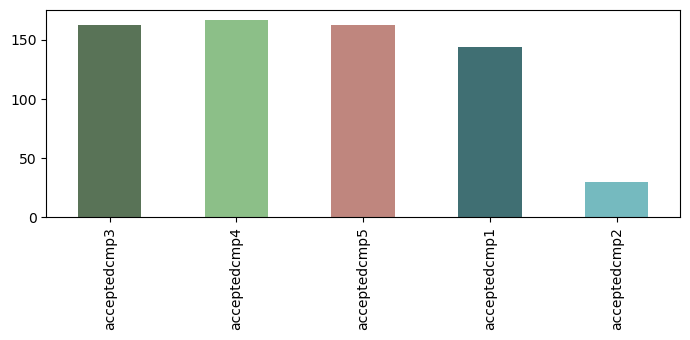

In [24]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF', '#BF75A1', '#6BB9BF', '#95BF91']

cols = ['acceptedcmp3',
        'acceptedcmp4',
        'acceptedcmp5',
        'acceptedcmp1',
       'acceptedcmp2']

df[cols].sum().plot.bar(color=colors)

In [25]:
df['complain'][df['complain'] > 0].count()

21

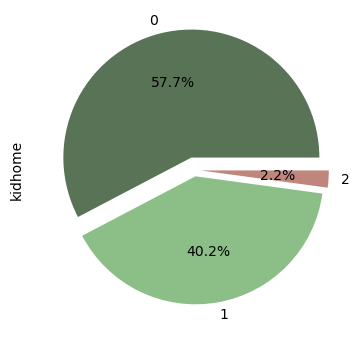

In [26]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF']
explode = [0.1,0.05,0.05]

df['kidhome'].value_counts().plot(kind = 'pie', autopct='%.1f%%', colors=colors, explode=explode)
plt.show()

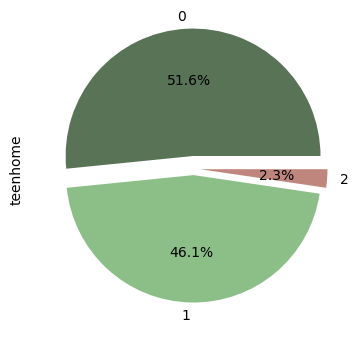

In [27]:
colors = ['#597357', '#8CBF88', '#BF867E', '#406F73', '#75BABF']
explode = [0.1,0.05,0.05]

df['teenhome'].value_counts().plot(kind = 'pie', autopct='%.1f%%', colors=colors, explode=explode)
plt.show()

array([[<AxesSubplot: title={'center': 'income'}>]], dtype=object)

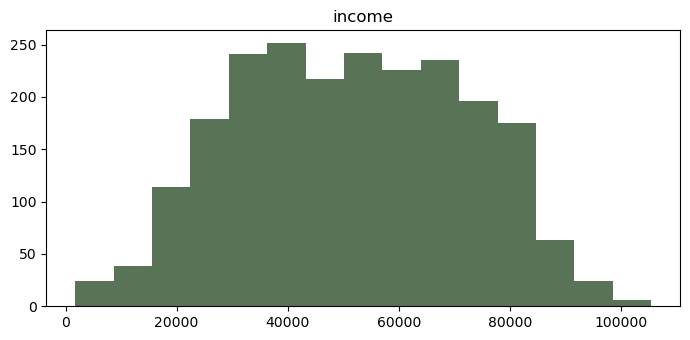

In [28]:
df.hist(column='income', bins=15, color = '#597357', grid=False)

array([[<AxesSubplot: title={'center': 'recency'}>]], dtype=object)

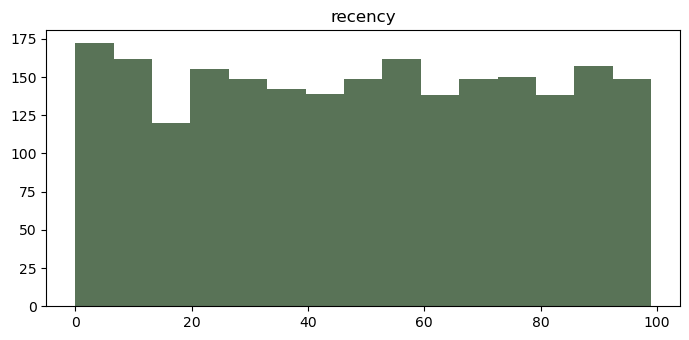

In [29]:
df.hist(column='recency', bins=15, color = '#597357', grid=False)

Promotion:
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

In [30]:
df['numdealspurchases'].sum()

5174

In [31]:
campaigns = ['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5']

In [32]:
for n in campaigns:
    print(n, df[n].sum())

acceptedcmp1 144
acceptedcmp2 30
acceptedcmp3 163
acceptedcmp4 167
acceptedcmp5 163


In [33]:
df["dt_customer"] = pd.to_datetime(df["dt_customer"])

In [34]:
df["dt_customer"].max()

Timestamp('2014-06-29 00:00:00')

In [35]:
df['response']

0       1
1       0
2       0
3       0
4       0
       ..
2235    0
2236    0
2237    0
2238    0
2239    1
Name: response, Length: 2231, dtype: int64

In [36]:
df[categorical].nunique()

education           5
marital_status      8
dt_customer       663
dtype: int64

I will create a new feature against the date 2014:
- `cust_age`

In [37]:
df['cust_age'] = 2015 - df['year_birth']

In [38]:
df['cust_age'].head()

0    58
1    61
2    50
3    31
4    34
Name: cust_age, dtype: int64

In [39]:
df.drop(columns='year_birth')

,id,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,...,numstorepurchases,numwebvisitsmonth,acceptedcmp3,acceptedcmp4,acceptedcmp5,acceptedcmp1,acceptedcmp2,complain,response,cust_age
0,5524,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,4,7,0,0,0,0,0,0,1,58
1,2174,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,2,5,0,0,0,0,0,0,0,61
2,4141,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,10,4,0,0,0,0,0,0,0,50
3,6182,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,4,6,0,0,0,0,0,0,0,31
4,5324,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,6,5,0,0,0,0,0,0,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,...,4,5,0,0,0,0,0,0,0,48
2236,4001,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,...,5,7,0,0,0,1,0,0,0,69
2237,7270,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,...,13,6,0,1,0,0,0,0,0,34
2238,8235,Master,Together,69245.0,0,1,2014-01-24,8,428,30,...,10,3,0,0,0,0,0,0,0,59


In [40]:
df.to_csv('cleaned-marketing-campaign.csv')

In [41]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=len(df_test), random_state=11)
len(df_train), len(df_test), len(df_val)

(1337, 447, 447)

In [42]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [43]:
y_train = df_train.response.values
y_val = df_val.response.values
y_test = df_test.response.values

In [44]:
del df_train['response']
del df_val['response']
del df_test['response']

In [45]:
df_train.head().T

,0,1,2,3,4
id,1177,4856,3570,2986,5534
year_birth,1966,1957,1969,1976,1975
education,Master,2n Cycle,PhD,Graduation,Master
marital_status,Together,Married,Together,Married,Married
income,49618.0,82347.0,42731.0,30772.0,47808.0
kidhome,1,0,1,1,0
teenhome,1,0,0,1,1
dt_customer,2013-01-26 00:00:00,2012-11-06 00:00:00,2013-10-21 00:00:00,2014-03-12 00:00:00,2013-10-20 00:00:00
recency,77,38,64,89,30
mntwines,80,556,159,7,123


In [46]:
def mutual_info_response_score(series):
    return mutual_info_score(df_full_train.response, series)

In [47]:
df_full_train[categorical].apply(mutual_info_response_score)

education         0.006806
marital_status    0.008836
dt_customer       0.198412
dtype: float64

In [48]:
numerical = list(df_train.dtypes[df_train.dtypes == 'int64'].index)

In [49]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)

In [50]:
mis = df_train[numerical].corrwith(df_full_train.response)
mis.sort_values(ascending=False)

mntfishproducts        0.060858
numstorepurchases      0.034360
acceptedcmp5           0.031374
mntwines               0.028839
acceptedcmp1           0.023973
recency                0.021486
id                     0.018940
mntfruits              0.017586
numwebpurchases        0.015010
mntmeatproducts        0.014407
mntsweetproducts       0.013598
mntgoldprods           0.013582
year_birth             0.007336
numcatalogpurchases    0.000571
acceptedcmp4          -0.001588
cust_age              -0.007336
complain              -0.009271
numdealspurchases     -0.015592
teenhome              -0.017341
acceptedcmp2          -0.031686
kidhome               -0.034559
numwebvisitsmonth     -0.038144
acceptedcmp3          -0.066713
dtype: float64

## One-hot encoding

In [51]:
dv = DictVectorizer(sparse=False)

In [52]:
train_dicts = df_train[categorical + numerical].to_dict('records')
train_dicts[0]

{'education': 'Master',
 'marital_status': 'Together',
 'id': 1177,
 'year_birth': 1966,
 'kidhome': 1,
 'teenhome': 1,
 'recency': 77,
 'mntwines': 80,
 'mntfruits': 3,
 'mntmeatproducts': 26,
 'mntfishproducts': 4,
 'mntsweetproducts': 2,
 'mntgoldprods': 14,
 'numdealspurchases': 4,
 'numwebpurchases': 3,
 'numcatalogpurchases': 1,
 'numstorepurchases': 3,
 'numwebvisitsmonth': 7,
 'acceptedcmp3': 0,
 'acceptedcmp4': 0,
 'acceptedcmp5': 0,
 'acceptedcmp1': 0,
 'acceptedcmp2': 0,
 'complain': 0,
 'cust_age': 49}

In [53]:
dv.fit(train_dicts)

DictVectorizer(sparse=False)

In [54]:
dv.get_feature_names_out()

array(['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4',
       'acceptedcmp5', 'complain', 'cust_age', 'education=2n Cycle',
       'education=Basic', 'education=Graduation', 'education=Master',
       'education=PhD', 'id', 'kidhome', 'marital_status=Alone',
       'marital_status=Divorced', 'marital_status=Married',
       'marital_status=Single', 'marital_status=Together',
       'marital_status=Widow', 'marital_status=YOLO', 'mntfishproducts',
       'mntfruits', 'mntgoldprods', 'mntmeatproducts', 'mntsweetproducts',
       'mntwines', 'numcatalogpurchases', 'numdealspurchases',
       'numstorepurchases', 'numwebpurchases', 'numwebvisitsmonth',
       'recency', 'teenhome', 'year_birth'], dtype=object)

In [55]:
dv.transform(train_dicts)

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 7.700e+01, 1.000e+00,
        1.966e+03],
       [1.000e+00, 0.000e+00, 1.000e+00, ..., 3.800e+01, 0.000e+00,
        1.957e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 6.400e+01, 0.000e+00,
        1.969e+03],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 6.500e+01, 1.000e+00,
        1.953e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 6.800e+01, 0.000e+00,
        1.964e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.900e+01, 1.000e+00,
        1.972e+03]])

In [56]:
train_dicts

[{'education': 'Master',
  'marital_status': 'Together',
  'id': 1177,
  'year_birth': 1966,
  'kidhome': 1,
  'teenhome': 1,
  'recency': 77,
  'mntwines': 80,
  'mntfruits': 3,
  'mntmeatproducts': 26,
  'mntfishproducts': 4,
  'mntsweetproducts': 2,
  'mntgoldprods': 14,
  'numdealspurchases': 4,
  'numwebpurchases': 3,
  'numcatalogpurchases': 1,
  'numstorepurchases': 3,
  'numwebvisitsmonth': 7,
  'acceptedcmp3': 0,
  'acceptedcmp4': 0,
  'acceptedcmp5': 0,
  'acceptedcmp1': 0,
  'acceptedcmp2': 0,
  'complain': 0,
  'cust_age': 49},
 {'education': '2n Cycle',
  'marital_status': 'Married',
  'id': 4856,
  'year_birth': 1957,
  'kidhome': 0,
  'teenhome': 0,
  'recency': 38,
  'mntwines': 556,
  'mntfruits': 54,
  'mntmeatproducts': 845,
  'mntfishproducts': 202,
  'mntsweetproducts': 133,
  'mntgoldprods': 63,
  'numdealspurchases': 1,
  'numwebpurchases': 7,
  'numcatalogpurchases': 7,
  'numstorepurchases': 10,
  'numwebvisitsmonth': 3,
  'acceptedcmp3': 1,
  'acceptedcmp4': 0

In [57]:
X_train = dv.fit_transform(train_dicts)
X_train.shape

(1337, 35)

In [58]:
val_dicts = df_val[categorical + numerical].to_dict('records')
val_dicts[0]

{'education': 'Graduation',
 'marital_status': 'Divorced',
 'id': 2429,
 'year_birth': 1954,
 'kidhome': 0,
 'teenhome': 1,
 'recency': 4,
 'mntwines': 531,
 'mntfruits': 69,
 'mntmeatproducts': 300,
 'mntfishproducts': 150,
 'mntsweetproducts': 138,
 'mntgoldprods': 150,
 'numdealspurchases': 3,
 'numwebpurchases': 5,
 'numcatalogpurchases': 4,
 'numstorepurchases': 8,
 'numwebvisitsmonth': 2,
 'acceptedcmp3': 0,
 'acceptedcmp4': 0,
 'acceptedcmp5': 0,
 'acceptedcmp1': 0,
 'acceptedcmp2': 0,
 'complain': 0,
 'cust_age': 61}

In [59]:
X_val = dv.transform(val_dicts)
X_val.shape

(447, 35)

## Logistic Regression model

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/don/miniconda3/envs/zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
model.intercept_[0]

-1.5614922245893233e-05

In [62]:
model.coef_[0].round(3)

array([ 0.006,  0.002,  0.009,  0.004,  0.007,  0.   , -0.031, -0.001,
       -0.   , -0.004,  0.   ,  0.005, -0.   ,  0.003,  0.   ,  0.002,
       -0.006,  0.005, -0.001,  0.001, -0.   , -0.   , -0.003,  0.004,
        0.001, -0.002,  0.002,  0.024,  0.009, -0.06 ,  0.016,  0.043,
       -0.029, -0.008,  0.   ])

In [63]:
model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
model.predict_proba(X_train)[:, 1]

array([0.0334105 , 0.23393037, 0.04985767, ..., 0.02269462, 0.11824126,
       0.06525432])

In [65]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.32088514, 0.21217034, 0.11581248, 0.05531177, 0.0647677 ,
       0.26719794, 0.10011361, 0.03230217, 0.45053959, 0.20219293,
       0.02078969, 0.16061771, 0.41239535, 0.06629054, 0.08969059,
       0.12761047, 0.07053829, 0.06278438, 0.21610086, 0.53402403,
       0.6086649 , 0.24699481, 0.38771141, 0.08249501, 0.08380798,
       0.25889515, 0.11363292, 0.20796638, 0.11816938, 0.19087963,
       0.0328496 , 0.37884372, 0.08751642, 0.10344988, 0.17686163,
       0.10676514, 0.31076997, 0.01566582, 0.03668879, 0.01789097,
       0.04806342, 0.0753809 , 0.07086492, 0.13638831, 0.11323642,
       0.34341712, 0.20069048, 0.44108075, 0.21894556, 0.14193902,
       0.06952221, 0.10196407, 0.44376466, 0.1037981 , 0.02353288,
       0.08243644, 0.03119124, 0.05933994, 0.18144327, 0.06293803,
       0.04671953, 0.18833223, 0.25944587, 0.1332104 , 0.05158638,
       0.84188735, 0.05885487, 0.15622509, 0.12209052, 0.1015365 ,
       0.1685614 , 0.10070106, 0.32779167, 0.02657752, 0.02047

In [66]:
response_decision = y_pred >= 0.5

In [67]:
df_val[response_decision].id

19      1859
20      9493
65      7962
115     2930
122     3005
161     1729
221     4702
229     7101
303    10673
347     1103
389     1772
390     9560
426     9242
432     1631
433     1031
443     2176
Name: id, dtype: int64

In [68]:
response_decision.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [69]:
(y_val == response_decision).mean()

0.8501118568232662

In [70]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = response_decision.astype(int)
df_pred['actual'] = y_val
df_pred

,probability,prediction,actual
0,0.320885,0,0
1,0.212170,0,0
2,0.115812,0,1
3,0.055312,0,0
4,0.064768,0,0
...,...,...,...
442,0.109387,0,0
443,0.581072,1,1
444,0.017227,0,1
445,0.048250,0,0


In [71]:
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred

,probability,prediction,actual,correct
0,0.320885,0,0,True
1,0.212170,0,0,True
2,0.115812,0,1,False
3,0.055312,0,0,True
4,0.064768,0,0,True
...,...,...,...,...
442,0.109387,0,0,True
443,0.581072,1,1,True
444,0.017227,0,1,False
445,0.048250,0,0,True


In [72]:
df_pred.correct.mean()

0.8501118568232662

## Decision Tree

In [73]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [74]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [75]:
roc_auc_score(y_val, y_pred)

0.641332034761762

In [76]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [77]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [78]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.8508379688422258
val: 0.664743781839976


In [79]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.632
   2 -> 0.650
   3 -> 0.698
   4 -> 0.702
   5 -> 0.681
   6 -> 0.592
  10 -> 0.648
  15 -> 0.658
  20 -> 0.654
None -> 0.665


In [80]:
for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (m, auc))

1 -> 0.719
5 -> 0.741
10 -> 0.739
15 -> 0.740
20 -> 0.734
50 -> 0.747
100 -> 0.715
200 -> 0.688


In [81]:
for m in [4, 5, 6]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    
    print()

depth: 4
1 -> 0.702
5 -> 0.728
10 -> 0.740
15 -> 0.740
20 -> 0.734
50 -> 0.747
100 -> 0.715
200 -> 0.688

depth: 5
1 -> 0.654
5 -> 0.731
10 -> 0.747
15 -> 0.758
20 -> 0.763
50 -> 0.767
100 -> 0.728
200 -> 0.688

depth: 6
1 -> 0.597
5 -> 0.682
10 -> 0.730
15 -> 0.784
20 -> 0.788
50 -> 0.785
100 -> 0.740
200 -> 0.688



In [82]:

for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (m, auc))

1 -> 0.623
5 -> 0.681
10 -> 0.728
15 -> 0.783
20 -> 0.788
50 -> 0.785
100 -> 0.740
200 -> 0.688


In [83]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.7883765358106082

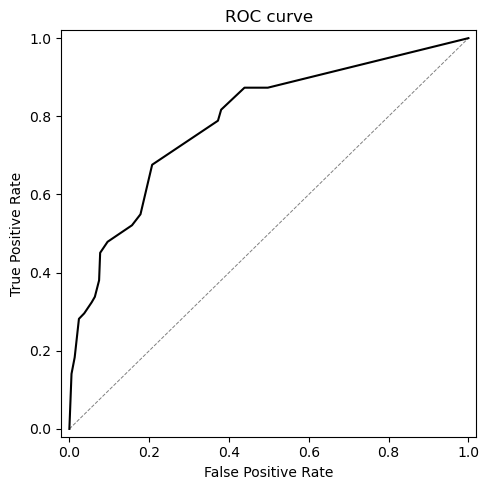

In [84]:
fpr, tpr, _ = roc_curve(y_val, y_pred_dt)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

In [85]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

## Ensemble and random forest

In [86]:
rf = RandomForestClassifier(n_estimators=10, random_state=11)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7738799820197781

In [87]:
aucs = []

for i in range(100):
    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

print('%.3f +- %.3f' % (auc_mean, auc_std))
print('%.3f -- %.3f' % (auc_mean -  auc_std, auc_mean + auc_std))

0.811 +- 0.018
0.793 -- 0.828


In [88]:
aucs = []

for i in range(10, 501, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

10 -> 0.796
20 -> 0.832
30 -> 0.846
40 -> 0.851
50 -> 0.848
60 -> 0.851
70 -> 0.855
80 -> 0.856
90 -> 0.859
100 -> 0.860
110 -> 0.860
120 -> 0.861
130 -> 0.862
140 -> 0.862
150 -> 0.862
160 -> 0.861
170 -> 0.859
180 -> 0.860
190 -> 0.860
200 -> 0.861
210 -> 0.861
220 -> 0.863
230 -> 0.863
240 -> 0.862
250 -> 0.863
260 -> 0.863
270 -> 0.863
280 -> 0.863
290 -> 0.863
300 -> 0.864
310 -> 0.864
320 -> 0.864
330 -> 0.865
340 -> 0.865
350 -> 0.865
360 -> 0.865
370 -> 0.864
380 -> 0.864
390 -> 0.864
400 -> 0.865
410 -> 0.865
420 -> 0.866
430 -> 0.865
440 -> 0.865
450 -> 0.865
460 -> 0.865
470 -> 0.865
480 -> 0.865
490 -> 0.865
500 -> 0.865


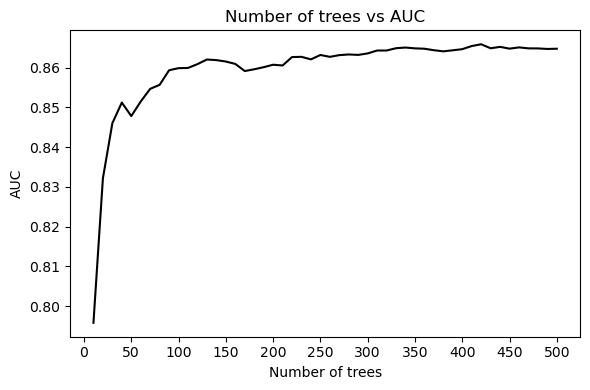

In [89]:
plt.figure(figsize=(6, 4))

plt.plot(range(10, 501, 10), aucs, color='black')
plt.xticks(range(0, 501, 50))

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators.svg')

plt.show()

In [90]:
all_aucs = {}

for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []

    for i in range(400, 501, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[depth] = aucs
    print()

depth: 5
400 -> 0.861
410 -> 0.860
420 -> 0.860
430 -> 0.860
440 -> 0.860
450 -> 0.859
460 -> 0.860
470 -> 0.860
480 -> 0.859
490 -> 0.859
500 -> 0.859

depth: 10
400 -> 0.867
410 -> 0.866
420 -> 0.867
430 -> 0.867
440 -> 0.867
450 -> 0.867
460 -> 0.867
470 -> 0.866
480 -> 0.866
490 -> 0.866
500 -> 0.865

depth: 20
400 -> 0.864
410 -> 0.864
420 -> 0.863
430 -> 0.862
440 -> 0.862
450 -> 0.862
460 -> 0.863
470 -> 0.863
480 -> 0.863
490 -> 0.863
500 -> 0.863



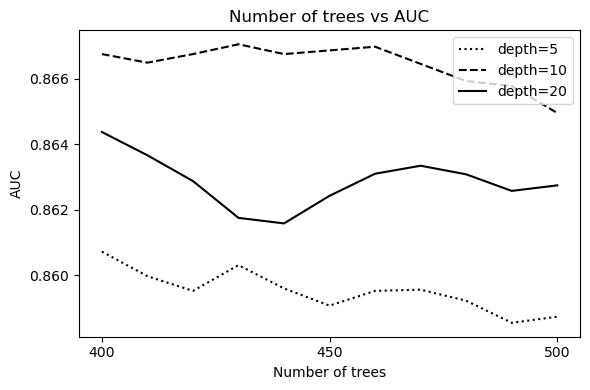

In [91]:
plt.figure(figsize=(6, 4))

num_trees = list(range(400, 501, 10))

plt.plot(num_trees, all_aucs[5], label='depth=5', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[20], label='depth=20', color='black', linestyle='solid')
    
plt.xticks(range(400, 501, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

In [92]:
all_aucs = {}

for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []

    for i in range(400, 501, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
400 -> 0.868
420 -> 0.868
440 -> 0.867
460 -> 0.868
480 -> 0.868
500 -> 0.868

min_samples_leaf: 5
400 -> 0.867
420 -> 0.867
440 -> 0.867
460 -> 0.867
480 -> 0.867
500 -> 0.867

min_samples_leaf: 10
400 -> 0.863
420 -> 0.864
440 -> 0.862
460 -> 0.861
480 -> 0.862
500 -> 0.862



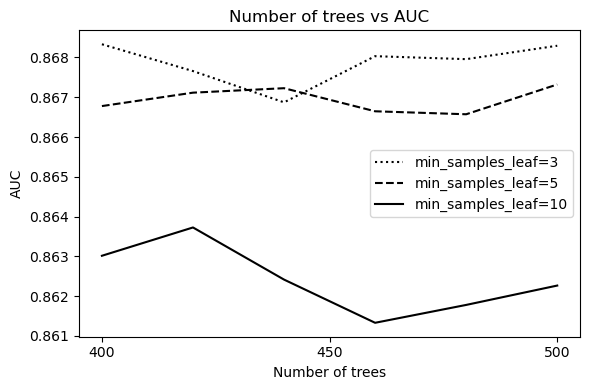

In [93]:
plt.figure(figsize=(6, 4))

num_trees = list(range(400, 501, 20))

plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10', color='black', linestyle='solid')
    
plt.xticks(range(400, 501, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_sample_leaf.svg')

plt.show()

In [94]:
rf = RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=400,
                       random_state=1)

In [95]:
y_pred_rf = rf.predict_proba(X_val)[:, 1]
random_forest = roc_auc_score(y_val, y_pred_rf)
random_forest

0.8683323344321247

## Gradient boosting and XGBOOST

In [96]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [97]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[00:14:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [98]:
y_pred = model.predict(dval)

In [99]:
roc_auc_score(y_val, y_pred)

0.8599602936769554

In [100]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [101]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=10,evals=watchlist)

In [102]:
s = output.stdout

In [103]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [104]:
df_score = parse_xgb_output(output)

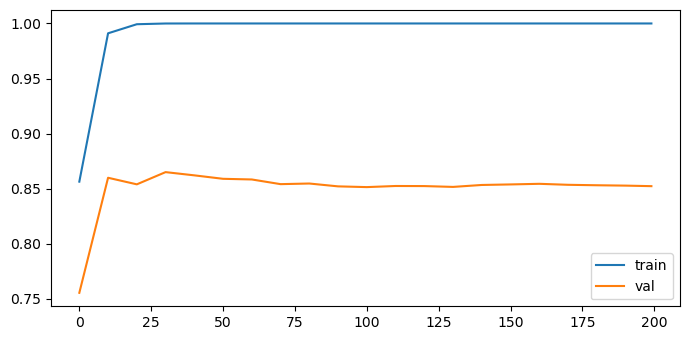

In [105]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [106]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [107]:
tree, aucs_train, aucs_val = parse_xgb_output(output)

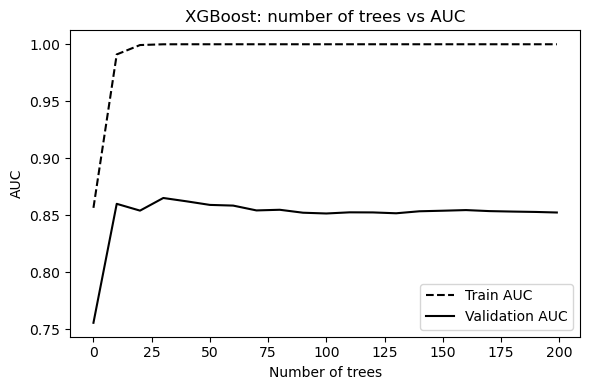

In [108]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_train, color='black', linestyle='dashed', label='Train AUC')
plt.plot(tree, aucs_val, color='black', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 201, 25))

plt.legend()

plt.title('XGBoost: number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_xgb_default.svg')

plt.show()

Let's tune some parameters

In [109]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [110]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.86506
(0.86506, 30)


In [111]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [112]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.8671
(0.8671, 120)


In [113]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [114]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.87097
(0.87097, 420)


In [115]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [116]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.86217
(0.86217, 499)


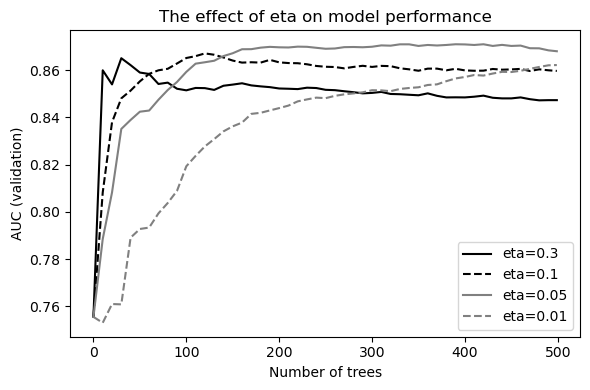

In [117]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, color='grey', linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, color='grey', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_eta.svg')

plt.show()

In [118]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [119]:
tree, _, aucs_val_depth3 = parse_xgb_output(output)
print(max(aucs_val_depth3))
print(max(zip(aucs_val_depth3, tree)))

0.85818
(0.85818, 130)


In [120]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [121]:
tree, _, aucs_val_depth10 = parse_xgb_output(output)
print(max(aucs_val))
print(max(zip(aucs_val_depth10, tree)))

0.86506
(0.86193, 420)


In [122]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 15,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [123]:
tree, _, aucs_val_depth15 = parse_xgb_output(output)
print(max(aucs_val_depth15))
print(max(zip(aucs_val_depth15, tree)))

0.86966
(0.86966, 100)


In [124]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 12,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [125]:
tree, _, aucs_val_depth12 = parse_xgb_output(output)
print(max(aucs_val_depth12))
print(max(zip(aucs_val_depth12, tree)))

0.86316
(0.86316, 150)


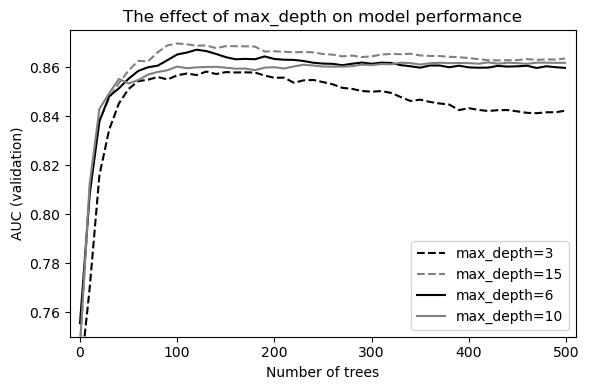

In [126]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_depth3, color='black', linestyle='dashed', label='max_depth=3')
plt.plot(tree, aucs_val_depth15, color='grey', linestyle='dashed', label='max_depth=15')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='solid', label='max_depth=6')
plt.plot(tree, aucs_val_depth10, color='grey', linestyle='solid', label='max_depth=10')

plt.ylim(0.75, 0.875)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of max_depth on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_depth.svg')

plt.show()

In [127]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [128]:
tree, _, aucs_val_mcw1 = parse_xgb_output(output)
print(max(aucs_val_mcw1))
print(max(zip(aucs_val_mcw1, tree)))

0.85818
(0.85818, 130)


In [129]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [130]:
tree, _, aucs_val_mcw10 = parse_xgb_output(output)
print(max(aucs_val_mcw10))
print(max(zip(aucs_val_mcw10, tree)))

0.86594
(0.86594, 130)


In [131]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [132]:
tree, _, aucs_val_mcw30 = parse_xgb_output(output)
print(max(aucs_val_mcw30))
print(max(zip(aucs_val_mcw30, tree)))

0.81162
(0.81162, 40)


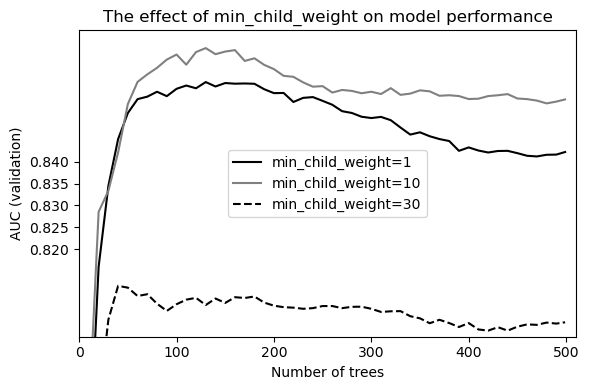

In [133]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_mcw1, color='black', linestyle='solid', label='min_child_weight=1')
plt.plot(tree, aucs_val_mcw10, color='grey', linestyle='solid', label='min_child_weight=10')
plt.plot(tree, aucs_val_mcw30, color='black', linestyle='dashed', label='min_child_weight=30')

plt.ylim(0.80, 0.87)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.82, 0.84, 5))

plt.legend()

plt.title('The effect of min_child_weight on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_mcw.svg')

plt.show()

In [134]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [135]:
print(output)

[0]	train-auc:0.78676	val-auc:0.73225
[10]	train-auc:0.85076	val-auc:0.76998
[20]	train-auc:0.91117	val-auc:0.81598
[30]	train-auc:0.93524	val-auc:0.83445
[40]	train-auc:0.94677	val-auc:0.84515
[50]	train-auc:0.95685	val-auc:0.85110
[60]	train-auc:0.96410	val-auc:0.85428
[70]	train-auc:0.97016	val-auc:0.85485
[80]	train-auc:0.97359	val-auc:0.85597
[90]	train-auc:0.97723	val-auc:0.85496
[100]	train-auc:0.98117	val-auc:0.85664
[110]	train-auc:0.98413	val-auc:0.85739
[120]	train-auc:0.98660	val-auc:0.85676
[130]	train-auc:0.98883	val-auc:0.85818
[140]	train-auc:0.99049	val-auc:0.85717
[150]	train-auc:0.99154	val-auc:0.85796
[160]	train-auc:0.99300	val-auc:0.85781
[170]	train-auc:0.99457	val-auc:0.85786
[180]	train-auc:0.99525	val-auc:0.85779
[190]	train-auc:0.99617	val-auc:0.85655
[200]	train-auc:0.99685	val-auc:0.85565
[210]	train-auc:0.99730	val-auc:0.85569
[220]	train-auc:0.99778	val-auc:0.85363
[230]	train-auc:0.99822	val-auc:0.85457
[240]	train-auc:0.99847	val-auc:0.85475
[250]	train

In [136]:
tree, _, aucs_val = parse_xgb_output(output)
print(max(aucs_val))

0.85818


In [137]:
max(zip(aucs_val, tree))

(0.85818, 130)

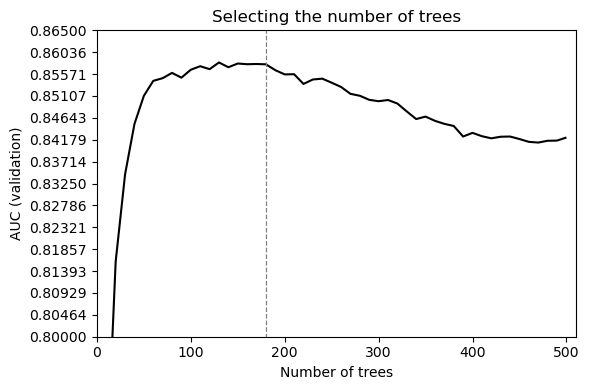

In [138]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val, color='black', linestyle='solid')


plt.ylim(0.80, 0.865)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.80, 0.865, 15))


plt.vlines(180, 0, 1, color='grey', linestyle='dashed', linewidth=0.9)

plt.title('Selecting the number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_number_trees.svg')

plt.show()

In [139]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 15,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=130, verbose_eval=10,
                  evals=watchlist)

[0]	train-auc:0.83497	val-auc:0.76058
[10]	train-auc:0.87655	val-auc:0.80836
[20]	train-auc:0.90466	val-auc:0.83175
[30]	train-auc:0.91943	val-auc:0.83745
[40]	train-auc:0.93115	val-auc:0.84039
[50]	train-auc:0.94003	val-auc:0.84421
[60]	train-auc:0.94805	val-auc:0.85331
[70]	train-auc:0.95345	val-auc:0.85799
[80]	train-auc:0.95789	val-auc:0.86170
[90]	train-auc:0.96220	val-auc:0.86588
[100]	train-auc:0.96576	val-auc:0.86798
[110]	train-auc:0.96897	val-auc:0.86880
[120]	train-auc:0.97134	val-auc:0.86895
[129]	train-auc:0.97329	val-auc:0.86903


In [140]:
y_pred_xgb = model.predict(dval)

In [141]:
roc_auc_score(y_val, y_pred_xgb)

0.8690253221456399

In [142]:
print("Decision Tree: ", roc_auc_score(y_val, y_pred_dt))
print("Random Forest: ", roc_auc_score(y_val, y_pred_rf))
print("XGBOOST: ", roc_auc_score(y_val, y_pred_xgb))

Decision Tree:  0.7883765358106082
Random Forest:  0.8683323344321247
XGBOOST:  0.8690253221456399


In [143]:
print("Logistic Regression:", df_pred.correct.mean())

Logistic Regression: 0.8501118568232662


## The model we will use

In [15]:
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier

In [16]:
url = "https://raw.githubusercontent.com/DonAvery/my-ds-ml-education-journey/main/ml-zoomcamp/capstone/cleaned-marketing-campaign.csv"
df = pd.read_csv(url)

In [17]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train.response == 'default').astype('int').values
y_test = (df_test.response == 'default').astype('int').values

del df_train['response']
del df_test['response']

In [18]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [19]:
rf = RandomForestClassifier(n_estimators=400, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=400,
                       random_state=1)

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [21]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 15,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=130)

## Using BentoML to save our model

In [22]:
import bentoml

In [23]:
bentoml.xgboost.save_model(
    'cust_marketing_model',
    model,
    custom_objects={
        "dictVectorizer": dv
    }
)

Model(tag="cust_marketing_model:iqbwemd73k3xapd2", path="/home/don/bentoml/models/cust_marketing_model/iqbwemd73k3xapd2/")

In [15]:
import json

In [36]:
request = df_test.iloc[0].to_dict()
print(json.dumps(request, indent=2))

{
  "id": 2131,
  "year_birth": 1959,
  "education": "PhD",
  "marital_status": "Divorced",
  "income": 62859.0,
  "kidhome": 0,
  "teenhome": 1,
  "dt_customer": "2012-12-30",
  "recency": 37,
  "mntwines": 1063,
  "mntfruits": 89,
  "mntmeatproducts": 102,
  "mntfishproducts": 16,
  "mntsweetproducts": 12,
  "mntgoldprods": 25,
  "numdealspurchases": 4,
  "numwebpurchases": 9,
  "numcatalogpurchases": 4,
  "numstorepurchases": 6,
  "numwebvisitsmonth": 6,
  "acceptedcmp3": 0,
  "acceptedcmp4": 0,
  "acceptedcmp5": 0,
  "acceptedcmp1": 0,
  "acceptedcmp2": 0,
  "complain": 0,
  "cust_age": 56
}
